# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [1]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [2]:
# Only for kaggle
# !pip install torch_geometric -q

In [3]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
# !pip install distinctipy -q

In [2]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
import random
from torch_geometric.utils import from_networkx
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
url = "D:\Grad\Planify_Dataset\Graph\graphs\Graphs_real.pkl"

# for kaggle
# url = "/kaggle/input/planify-graphs-all-forms/graphs/Graphs_real.pkl"

<a id='func'></a>
### Functions used

In [3]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [4]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def collate_fn(graphs_list):
    batch = Batch.from_data_list([Data.from_(g) for g in graphs_list])
    return batch

<a id='wrangling'></a>
## Data wrangling


Graph with 8 nodes and 13 edges


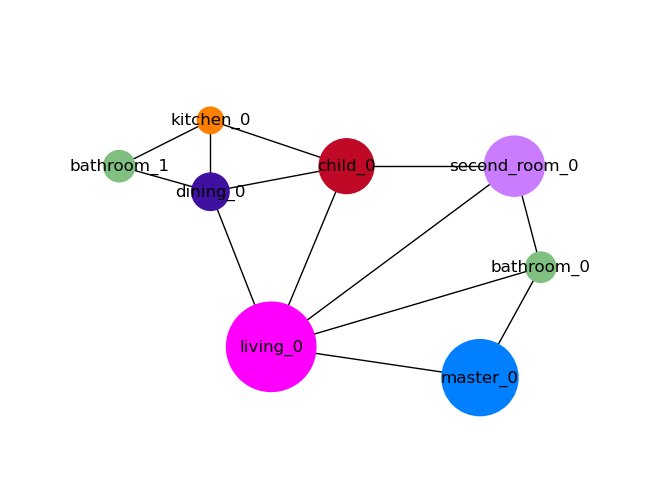

In [229]:
with open(url, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)
draw_graph(G)

In [7]:
# Converting networkx graphs to pytorchGeo graphs
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|██████████| 80787/80787 [00:59<00:00, 1358.21it/s]


Data(edge_index=[2, 18], roomType_name=[7], rec_w=[7], rec_h=[7], roomSize=[7], x=[7, 3], edge_attr=[18, 1])

> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [8]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6

    
print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  7.0000, 132.6687, 167.8575],
        [  7.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  9.0000,  77.0000, 210.5000]])


100%|██████████| 80787/80787 [00:06<00:00, 12766.60it/s]

After: G_1 embedings are: tensor([[  0.0000,  81.9371, 137.1722],
        [  1.0000, 181.5403, 165.1201],
        [  3.0000, 120.7426, 100.7954],
        [  1.0000, 132.6687, 167.8575],
        [  1.0000, 152.0459, 100.5418],
        [  3.0000, 192.0000, 127.0000],
        [  2.0000,  59.5000,  55.5000],
        [  4.0000,  77.0000, 210.5000]])


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [9]:
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    x = G.x # The feature matrix
    for i in [1, 2]:
        mean = torch.mean(x[:, i])
        std  = torch.std(x[:, i])
        
        normalized_column = (x[:, i] - mean) / std
        G.x[:, i] = normalized_column
    
    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

100%|██████████| 80787/80787 [00:19<00:00, 4175.63it/s]


> If we need to creat graphs with padding by the maximum number of nodes.

In [19]:
class GATNet(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(num_node_features, 32, heads=8)
        
        input_of_conv2 = 32*8 + 9  # output of conv1 + featurs of the real x = 9 => 265
        self.conv2 = GATConv(input_of_conv2, 64, heads=8)
        
        input_of_conv3 = 64*8 + 265 # output of conv2 + input of conv2 => 777
        self.conv3 = GATConv(input_of_conv3, 64, heads=8)
        
        input_of_conv4 = 64*8 + 777 # output of conv3 + input of conv3 => 1289
        self.conv4 = GATConv(input_of_conv4, 64, heads=8)
        
        input_of_conv5 = 64*8 + 1289 # output of conv3 + input of conv3 => 1801 
        self.conv5 = GATConv(input_of_conv5, 32, heads=4)
        
        input_of_lin1 = 32*4 + 1801 # => 1929
        self.lin1 = torch.nn.Linear(input_of_lin1, 64)
        
        input_of_lin2 = 64 + 1929 # => 1993
        self.lin2 = torch.nn.Linear(input_of_lin2, 64)
        self.regressior = torch.nn.Linear(64, 2)
        
        self.dropout = torch.nn.Dropout(p=0.25)
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        if batch == None:
            batch = torch.zeros(data.x.shape[0], dtype=torch.long)
        
        x_res = x # saving a copy of x for residual connection
        
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.conv2(x_res, edge_index, edge_attr))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.conv3(x_res, edge_index, edge_attr))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.conv4(x_res, edge_index, edge_attr))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1)
        x = F.relu(self.conv5(x_res, edge_index, edge_attr))
        x = self.dropout(x)       
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.lin1(x_res))
        x = self.dropout(x)
        
        x_res = torch.cat([x_res, x], dim=1) 
        x = F.relu(self.lin2(x_res))
        x = self.dropout(x)
        
        x = self.regressior(x)
        return x

num_features = Graphs_pyTorch[0].x.shape[1]
model = GATNet(num_features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# to monitor the loss & accuracy.
errors = []
acc = []

In [20]:
checkpoint_path = "D:\Grad\Graph-Neural-Networks\Regressions\squares_w_h\checkpoints\Best_model.pth"
checkpoint = torch.load(checkpoint_path)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']

model.eval()


GATNet(
  (conv1): GATConv(9, 32, heads=8)
  (conv2): GATConv(265, 64, heads=8)
  (conv3): GATConv(777, 64, heads=8)
  (conv4): GATConv(1289, 64, heads=8)
  (conv5): GATConv(1801, 32, heads=4)
  (lin1): Linear(in_features=1929, out_features=64, bias=True)
  (lin2): Linear(in_features=1993, out_features=64, bias=True)
  (regressior): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [198]:
class FloorPlan_multipolygon():
    def __init__(self, graph, prediction=None):
        self.graph       = graph
        self.prediction  = prediction
        
    def get_room_data(self, room_index):
        """
        Inputs: 
            room_index: index of the room in the graph
            
        Outputs: 
            centroid, w, h of that room.
        """
        Graph_data = list(self.graph.nodes(data=True))[room_index][1]
        w = Graph_data['rec_w']
        h = Graph_data['rec_h']
        centroid = (Graph_data['actualCentroid_x'], Graph_data['actualCentroid_y'])
        
        if isinstance(self.prediction, np.ndarray): # A  real array of predictions
            w_pre, h_pre = self.get_predictions(room_index)
            
        else:
            w_pre, h_pre = None, None
            
        data = {
            'centroid': centroid,
            'real_w': w,
            'real_h': h, 
            'predic_w': w_pre,
            'predic_h': h_pre
        }
        return data
    
    def create_box(self, room_data):
        """
        Inputs:
            room_data: a dictionary with centroid, w, h of that room.
            
        Outputs:
            box: a shapely box with the same centroid, w, h of that room.
        """
        centroid = room_data['centroid']
        if isinstance(self.prediction, np.ndarray): # A  real array of predictions
            half_w   = room_data['predic_w'] / 2
            half_h   = room_data['predic_h'] / 2
        
        else:
            half_w   = room_data['real_w'] / 2
            half_h   = room_data['real_h'] / 2

        bottom_left  = Point(centroid[0] - half_w, centroid[1] - half_h)
        bottom_right = Point(centroid[0] + half_w, centroid[1] - half_h)
        top_right    = Point(centroid[0] + half_w, centroid[1] + half_h)
        top_left     = Point(centroid[0] - half_w, centroid[1] + half_h)
        
        box = Polygon([bottom_left, bottom_right, top_right, top_left])
        return box

    def get_multipoly(self):
        """
        Outputs:
            multi_poly: a shapely multipolygon of all the rooms in the floor plan or graph.
        """
        num_of_rooms = self.graph.number_of_nodes()
        polygons = []
        for index in range(num_of_rooms):
            room_data = self.get_room_data(index)
            box = self.create_box(room_data)
            
            polygons.append(box)

        multi_poly = MultiPolygon(polygons)
        return multi_poly
    
    def get_predictions(self, room_index):
        """
        Inputs: 
            room_index: index of the room in the graph
        outputs: 
            w_predicted: predicted width for that room
            h_predicted: predicted width for that room
        """
        w_predicted = self.prediction[:, 0]
        h_predicted = self.prediction[:, 1]
        
        return w_predicted[room_index], h_predicted[room_index]

## Testing Our model

> The real graph

> 

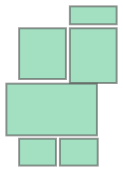

In [236]:
Graph_index = 7000
f = FloorPlan_multipolygon(Graphs[Graph_index], prediction=None)
f.get_multipoly()

> The predicted graph

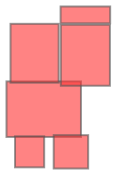

In [237]:
w_h_predicted = model(Graphs_pyTorch[Graph_index].to(device)).detach().cpu().numpy()

f = FloorPlan_multipolygon(Graphs[Graph_index], prediction=w_h_predicted)
f.get_multipoly()